## Семинар 9: "LSTM"

ФИО: Находнов Максим Сергеевич

In [539]:
import sys 

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

import pandas

In [540]:
torch.cuda.set_device(2)

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Переделайте следующую реализацию LSTM без использования циклов.

In [541]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.sigm = nn.Sigmoid().cuda()
        self.tanh = nn.Tanh().cuda()
        
        self.w_f_i = nn.Parameter(torch.Tensor(hidden_size, input_size).cuda().normal_())
        self.w_f_h = nn.Parameter(torch.Tensor(hidden_size, hidden_size).cuda().normal_())

        self.w_i_i = nn.Parameter(torch.Tensor(hidden_size, input_size).cuda().normal_())
        self.w_i_h = nn.Parameter(torch.Tensor(hidden_size, hidden_size).cuda().normal_())

        self.w_c_i = nn.Parameter(torch.Tensor(hidden_size, input_size).cuda().normal_())
        self.w_c_h = nn.Parameter(torch.Tensor(hidden_size, hidden_size).cuda().normal_())

        self.w_o_i = nn.Parameter(torch.Tensor(output_size, input_size).cuda().normal_())
        self.w_o_h = nn.Parameter(torch.Tensor(output_size, hidden_size).cuda().normal_())

        self.b_f_i = nn.Parameter(torch.Tensor(hidden_size, 1).cuda().normal_())
        self.b_f_h = nn.Parameter(torch.Tensor(hidden_size, 1).cuda().normal_())

        self.b_i_i = nn.Parameter(torch.Tensor(hidden_size, 1).cuda().normal_())
        self.b_i_h = nn.Parameter(torch.Tensor(hidden_size, 1).cuda().normal_())

        self.b_c_i = nn.Parameter(torch.Tensor(hidden_size, 1).cuda().normal_())
        self.b_c_h = nn.Parameter(torch.Tensor(hidden_size, 1).cuda().normal_())

        self.b_o_i = nn.Parameter(torch.Tensor(output_size, 1).cuda().normal_())
        self.b_o_h = nn.Parameter(torch.Tensor(output_size, 1).cuda().normal_())

    # @X is a Variable with dims [batch_num, seq_len, input_dim]
    # result of forward is a Variable with dims [batch_num, seq_len, output_dim]
    def forward(self, X_, H=None, C=None):
        batch_num = X_.shape[0]
        seq_len = X_.shape[1]
        
        output = Variable(torch.Tensor(batch_num, seq_len, self.output_size)).cuda()
        for _ in xrange(seq_len):
            if np.random.binomial(1, 0.1) and _ > 0:
                X = output[:, _ - 1, :].clone().t()
            else:
                X = X_[:, _, :].t()
            if H is None:
                H = Variable(torch.zeros(self.hidden_size, batch_num), requires_grad=False).cuda()
            if C is None:
                C = Variable(torch.zeros(self.hidden_size, batch_num), requires_grad=False).cuda()

            f_i = self.sigm(torch.mm(self.w_f_h, H) + torch.mm(self.w_f_i, X) + self.b_f_h + self.b_f_i)
            input_i = self.sigm(torch.mm(self.w_i_h, H) + torch.mm(self.w_i_i, X) + self.b_i_i + self.b_i_h)

            C = f_i * C + input_i * self.tanh(torch.mm(self.w_c_h, H) + torch.mm(self.w_c_i, X) + self.b_c_i + self.b_c_h)
            output[:, _, :] = self.sigm(torch.mm(self.w_o_h, H) + torch.mm(self.w_o_i, X) + self.b_o_i + self.b_o_h).t()
            H = output[:, _, :].clone().t() * self.tanh(C)

        return output

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM сделать решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

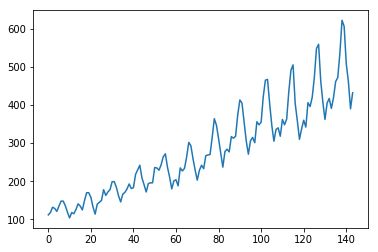

In [542]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [543]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

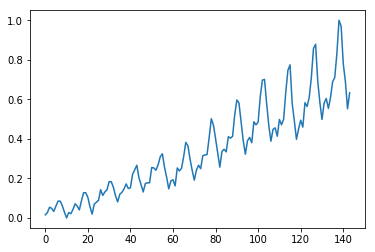

In [544]:
plt.plot(dataset.reshape(1, -1)[0])

In [545]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train_data), len(test_data))

(96, 48)


In [546]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+1:(i+1+look_back), 0])

    return np.array(dataX), np.array(dataY)

In [547]:
class PassengerDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [548]:
class LSTM_Wrapper(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM_Wrapper, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # LSTM ceil
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim)
        
        # Linear layer which transforms LSTM ceil' output 
        # of size hidden_dim to output of size output_dim
        self.outNN = nn.Sequential(
            nn.Linear(self.hidden_dim, self.output_dim)
        )
    
    # @X is a Variable with dims [batch_num, seq_len, input_dim]
    # result of forward is a Variable with dims [batch_num, seq_len, output_dim]
    def forward(self, X):
        X = X.clone()
        # LSTM input is a Variable with dims [seq_len, batch_num, input_dim]
        # LSTM output is a Variable with dims [seq_len, batch_num, hidden_dim]
        X = X.permute(1, 0, 2)
        output, (self.H, self.C) = self.lstm(X)
        output = output.permute(1, 0, 2)
        output = self.outNN(output)
        return output

In [549]:
def init_params(network):
    for name, param in network.named_parameters():
        if 'b' in name:
            nn.init.constant(param, 0.0)
        elif 'w' in name:
            nn.init.xavier_normal(param)

In [550]:
def train(network, loss, optimizer, scheduler, dataloader, epochs, look_back):
    epoch_losses = []
    try:
        for epoch in range(epochs):
            for X, y in dataloader:
                batch_losses = []
                
                X = Variable(X).view(X.shape[0], look_back, -1).cuda()
                y = Variable(y).view(X.shape[0], look_back, -1).cuda()

                network.zero_grad()

                predictions = network(X)
                loss_value = loss(predictions, y)
                loss_value.backward()
                optimizer.step()

                batch_losses.append(loss_value.cpu().data)
            epoch_losses.append(np.mean(batch_losses))
            scheduler.step()
            if epoch % 10 == 0:
                sys.stdout.write('\rEpoch {0}... (Train) MSE: {1:.10f}'.format(epoch, epoch_losses[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(epoch_losses, label='Losses')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [551]:
def predict(network, seq_begin, prediction_len):
    result = np.zeros(seq_begin.shape[0] + prediction_len)
    result[:seq_begin.shape[0]] = seq_begin
    for _ in xrange(prediction_len):
        X = Variable(torch.Tensor(result[_:_ + seq_begin.shape[0]])).view(1, seq_begin.shape[0], -1).cuda()
        p = network(X)
        result[_ + seq_begin.shape[0]] = p[0, -1, 0]
    return result[seq_begin.shape[0]:]

In [552]:
# Returns [network, optimizer, scheduler, loss, dataloader]
def make_train_eval_model(lstm_type, look_back, hidden_dim, epochs):
    net = None
    if lstm_type == 'custom':
        net = LSTM(1, hidden_dim, 1).cuda()
    else:
        net = LSTM_Wrapper(1, hidden_dim, 1).cuda()

    loss = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam(net.parameters(), 0.01)
    scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

    dataX, dataY = create_dataset(train_data, look_back)
    dataset = PassengerDataset(dataX, dataY)
    dataloader = DataLoader(dataset, shuffle=True, batch_size=64)
    
    train(*(net, loss, optimizer, scheduler, dataloader), epochs=epochs, look_back=look_back)
    
    start = 0
    end = start + look_back
    pred_len = 100
    seq = train_data[:,0]

    seq_begin = seq[start:end]
    pred = predict(network, seq_begin, pred_len)

    result_real = seq[start:end+pred_len]
    result_pred = np.append(seq_begin, pred)
    plt.plot(result_real, label='actual')
    plt.plot(result_pred, label='predicted')

    plt.legend(fontsize=14)

Epoch 990... (Train) MSE: 0.0013896093

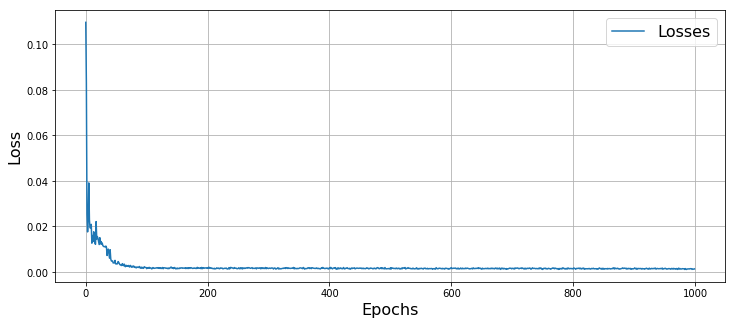

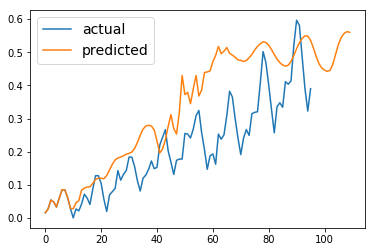

In [554]:
make_train_eval_model('non_custom', hidden_dim=10, look_back=10, epochs=1000)

Epoch 990... (Train) MSE: 0.0005834016

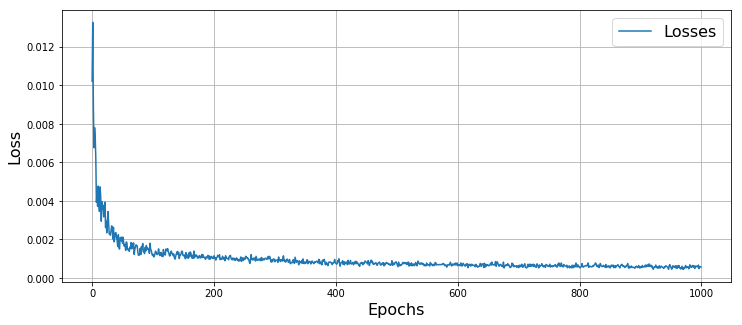

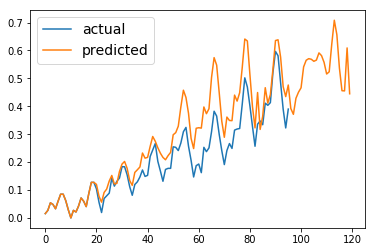

In [555]:
make_train_eval_model('non_custom', hidden_dim=10, look_back=20, epochs=1000)

Epoch 990... (Train) MSE: 0.0004471953

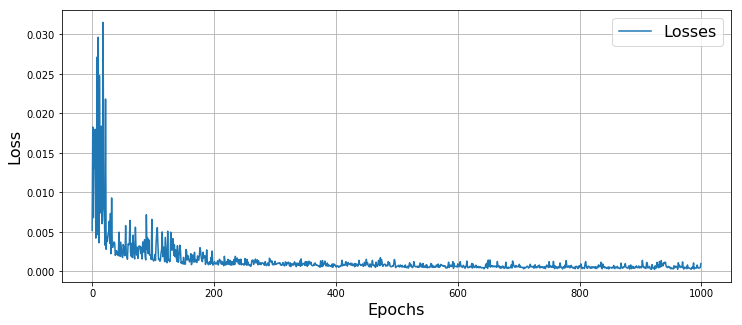

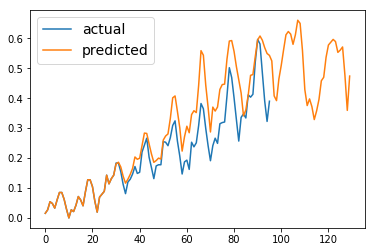

In [556]:
make_train_eval_model('non_custom', hidden_dim=10, look_back=30, epochs=1000)

Epoch 990... (Train) MSE: 0.0007533649

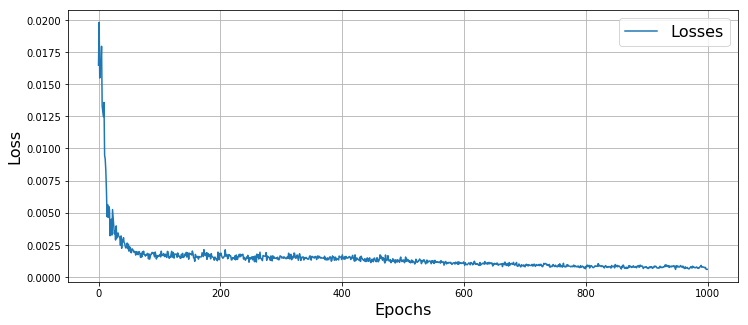

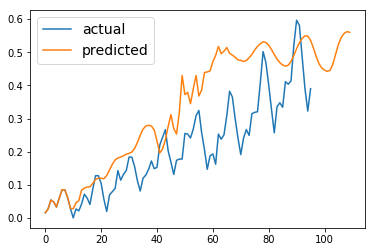

In [557]:
make_train_eval_model('non_custom', hidden_dim=20, look_back=10, epochs=1000)

Epoch 990... (Train) MSE: 0.0005266640

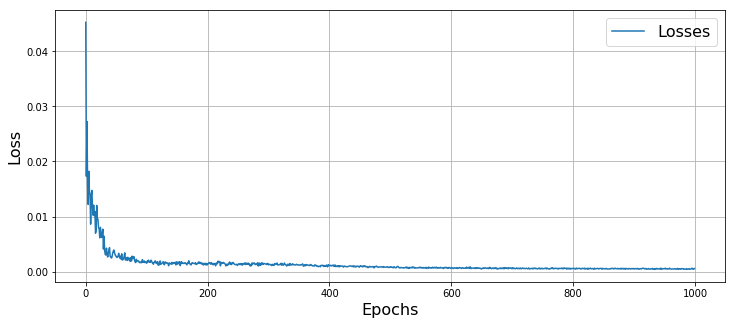

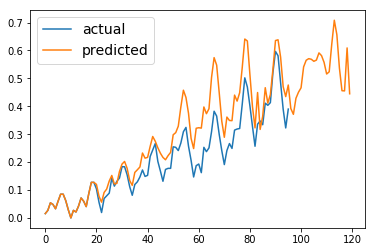

In [558]:
make_train_eval_model('non_custom', hidden_dim=20, look_back=20, epochs=1000)

Epoch 990... (Train) MSE: 0.0005821816

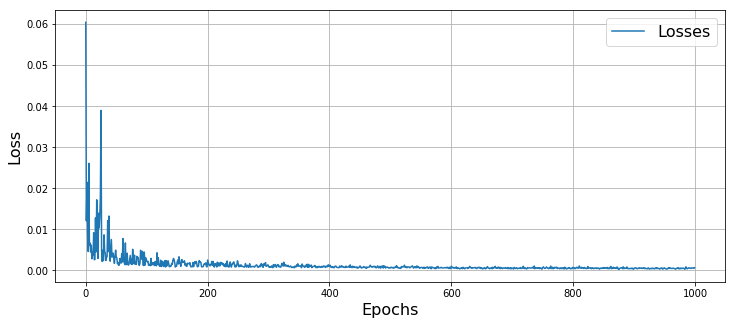

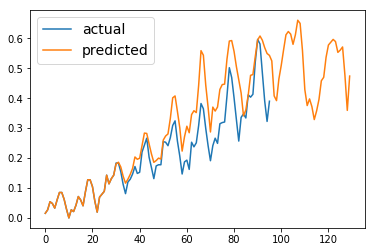

In [559]:
make_train_eval_model('non_custom', hidden_dim=20, look_back=30, epochs=1000)

Epoch 990... (Train) MSE: 0.0007008024

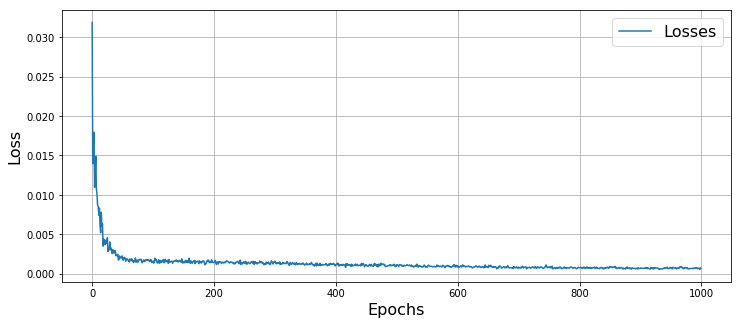

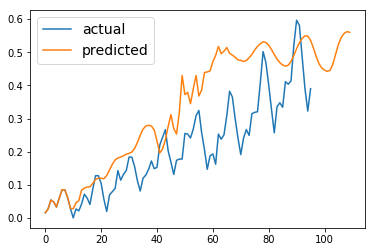

In [560]:
make_train_eval_model('non_custom', hidden_dim=30, look_back=10, epochs=1000)

Epoch 990... (Train) MSE: 0.0003802619

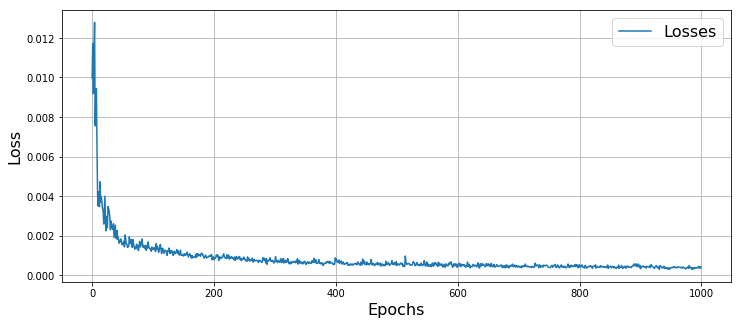

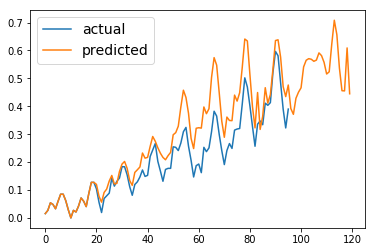

In [561]:
make_train_eval_model('non_custom', hidden_dim=30, look_back=20, epochs=1000)

Epoch 990... (Train) MSE: 0.0004630096

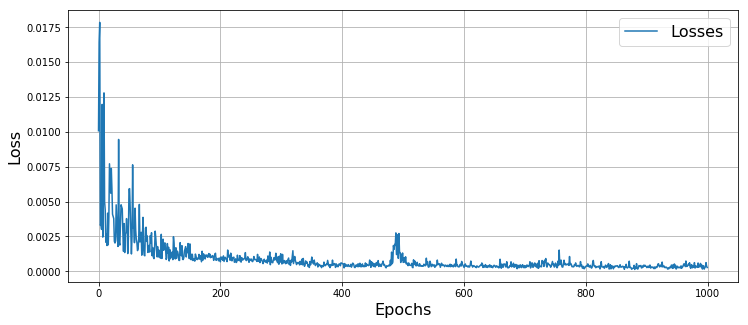

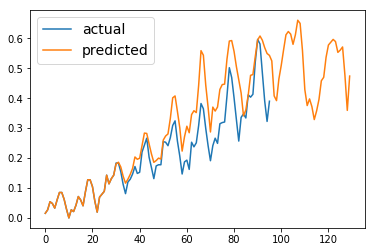

In [562]:
make_train_eval_model('non_custom', hidden_dim=30, look_back=30, epochs=1000)

Epoch 990... (Train) MSE: 0.0013520741

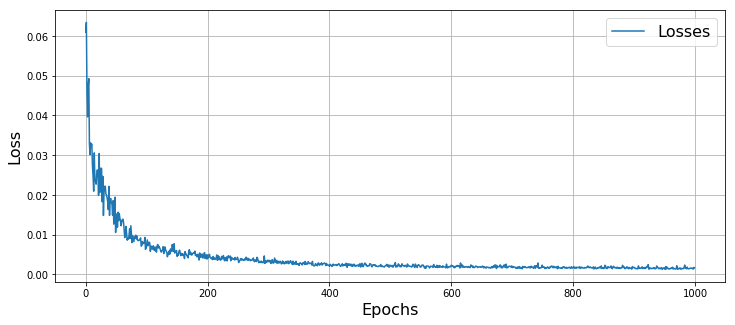

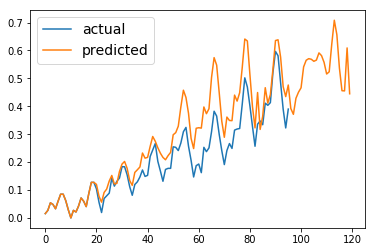

In [564]:
make_train_eval_model('custom', hidden_dim=20, look_back=20, epochs=1000)

Epoch 990... (Train) MSE: 0.0016508157

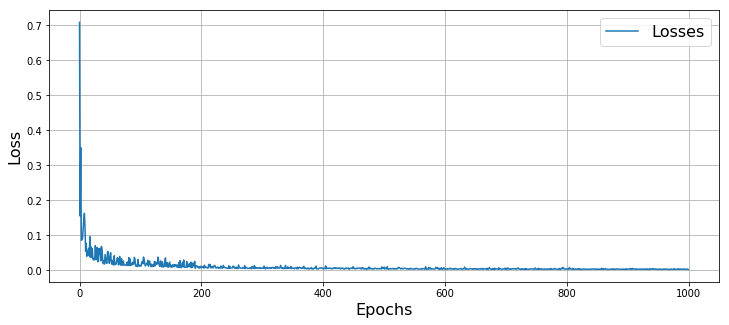

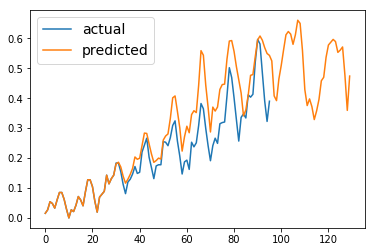

In [565]:
make_train_eval_model('custom', hidden_dim=30, look_back=30, epochs=1000)

* При предсказании по 10 точкам удовлетворительных результатов не получается.
* Предсказание по 20 точкам даёт приемлемый результат, но только в пределах той части данных, на которых можель обучалась
* Предсказание по 30 точкам уже позволяет экстраполировать тренд графика за пределы обучающей выборки

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: